In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../src")
import feature.molecule_dataset as molecule_dataset
import model.graph_adj_x_diffusion as graph_adj_x_diffusion
import model.graph_net as graph_net
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import rdkit
import IPython
import importlib

In [2]:
# Define device
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Define the branches and create the data loader

In [3]:
classes = [0, 1]
# branch_defs = [((0, 1), 0.5, 1), ((0,), 0, 0.5), ((1,), 0, 0.5)]

# branch_defs = [((0, 1), 0.3, 1), ((0,), 0, 0.3), ((1,), 0, 0.3)]

branch_defs = [((0, 1), 0.15, 1), ((0,), 0, 0.15), ((1,), 0, 0.15)]

# branch_defs = [((0, 1), 0.1, 1), ((0,), 0, 0.1), ((1,), 0, 0.1)]

In [4]:
dataset = molecule_dataset.ZINCDataset(label_method="heteroaromaticity")

# Limit classes
inds = np.isin(dataset.target, classes)
dataset.all_smiles = dataset.all_smiles[inds]
dataset.target = dataset.target[inds]

data_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=0)
input_shape = next(iter(data_loader))[0].shape[1:]

In [5]:
# TODO: this is currently rather inefficient; a decision-tree-style structure
# would be better

def class_time_to_branch(c, t):
    """
    Given a class and a time (both scalars), return the
    corresponding branch index.
    """
    for i, branch_def in enumerate(branch_defs):
        if c in branch_def[0] and t >= branch_def[1] and t <= branch_def[2]:
            return i
    raise ValueError("Undefined class and time")
        
def class_time_to_branch_tensor(c, t):
    """
    Given tensors of classes and a times, return the
    corresponding branch indices as a tensor.
    """
    return torch.tensor([
        class_time_to_branch(c_i, t_i) for c_i, t_i in zip(c, t)
    ], device=DEVICE)

In [6]:
# Create the SDE and model
sde = graph_adj_x_diffusion.AXJointSDE(0.1, 1, 0.2, 1, input_shape)

t_limit = 1

model = graph_net.GraphJointNetwork(
    len(branch_defs), t_limit,
    a_shared_layers=[True, True, True, True, True, False, False],
    x_shared_layers=[True, True, False]
).to(DEVICE)

# os.environ["MODEL_DIR"] = "/gstore/data/resbioai/tsenga5/branched_diffusion/models/trained_models/zinc250k_continuous_aromaticity"
os.environ["MODEL_DIR"] = "/gstore/scratch/u/tsenga5/branched_diffusion/models/trained_models/zinc250k_continuous_num_cycles_b0.1"
importlib.reload(graph_adj_x_diffusion)  # Reimport AFTER setting environment

<module 'model.graph_adj_x_diffusion' from '/gstore/home/tsenga5/branched_diffusion/notebooks/../src/model/graph_adj_x_diffusion.py'>

### Show the forward-diffusion process

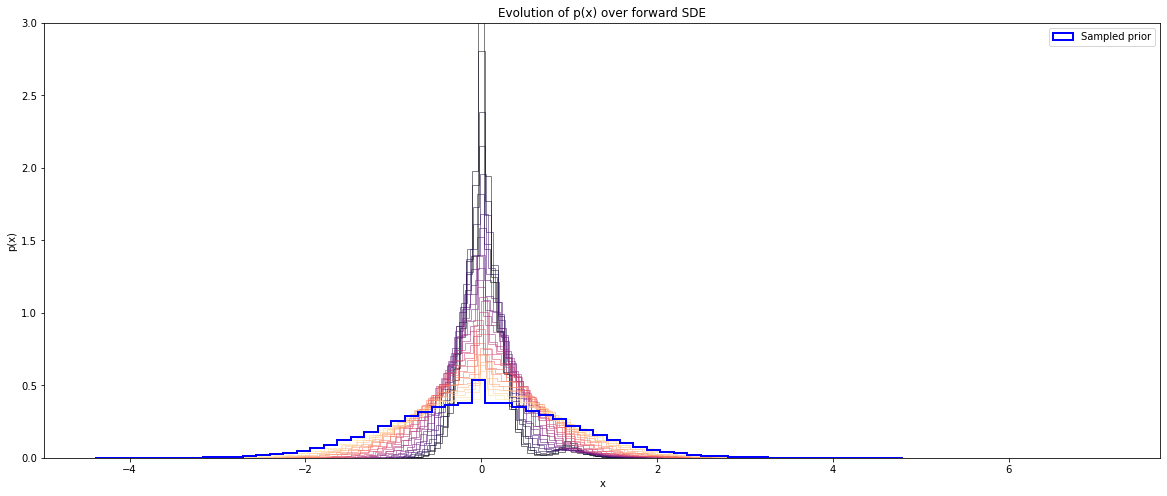

In [7]:
# Show the transformation of the distribution of data to the prior distribution
x0, _ = next(iter(data_loader))
x0 = x0.cpu().numpy()
x0 = torch.tensor(x0).to(DEVICE)

time_steps = 30

all_t = np.linspace(0, t_limit, time_steps)
all_xt = np.empty((len(all_t),) + x0.shape)
for t_i, t in enumerate(all_t):
    xt, _ = sde.forward(x0, torch.ones(len(x0)).to(DEVICE) * t)
    all_xt[t_i] = xt.cpu().numpy()

fig, ax = plt.subplots(figsize=(20, 8))
cmap = plt.get_cmap("magma")
for t_i in range(len(all_t)):
    ax.hist(np.ravel(all_xt[t_i]), bins=60, histtype="step", color=cmap(t_i / len(all_t)), alpha=0.5, density=True)
prior = sde.sample_prior(len(x0), torch.ones(len(x0)).to(DEVICE) * t).cpu().numpy()
ax.hist(np.ravel(prior), bins=60, histtype="step", color="blue", linewidth=2, density=True, label="Sampled prior")
ax.set_xlabel("x")
ax.set_ylabel("p(x)")
ax.set_title("Evolution of p(x) over forward SDE")
ax.set_ylim((0, 3))
plt.legend()
plt.show()

### Train the model

In [8]:
import model.util as model_util
model = model_util.load_model(
    graph_net.GraphJointNetwork,
    "/gstore/scratch/u/tsenga5/branched_diffusion/models/trained_models/zinc250k_continuous_heteroaromaticity_b0.15/1/last_ckpt.pth"
).to(DEVICE)

In [9]:
# graph_adj_x_diffusion.train_ex.run(
#     "train_branched_model",
#     config_updates={
#         "model": model,
#         "sde": sde,
#         "data_loader": data_loader,
#         "class_time_to_branch_index": class_time_to_branch_tensor,
#         "num_epochs": 200,
#         "learning_rate": 1e-3,
#         "t_limit": t_limit,
#         "loss_weighting_type": "empirical_norm"
#     }
# )

### Show generated distributions

In [10]:
samples = {}
num_samples_per_class = 32
for class_to_sample in classes:
    # Sample some initial node flags
    inds = np.random.choice(np.where(dataset.target == class_to_sample)[0], size=num_samples_per_class, replace=True)
    batch = torch.stack([dataset[i][0] for i in inds], dim=0)
    adj = batch[:, :, :batch.shape[1]]
    sampled_flags = graph_net.node_flags(adj)
    
    sample = graph_adj_x_diffusion.generate_continuous_branched_samples(
        model, sde, class_to_sample, class_time_to_branch_tensor,
        sampled_flags, num_samples=num_samples_per_class, t_limit=t_limit,
        num_steps=1000, verbose=True
    ).cpu().numpy()
    samples[class_to_sample] = sample

100%|██████████████████████████████████████████████████████████████| 1000/1000 [01:43<00:00,  9.69it/s]


In [11]:
ATOM_SYMBOLS = ["C", "N", "O", "F", "S", "Cl", "Br", "I", "P"]
BOND_TYPES = [rdkit.Chem.rdchem.BondType.SINGLE, rdkit.Chem.rdchem.BondType.DOUBLE, rdkit.Chem.rdchem.BondType.TRIPLE]

def samples_to_adj_x(samps):
    """
    Given a B x M x (M + D) array of adjacency matrices and node features,
    discretizes them and returns the adjacency matrices (B x M x M) and
    node features (B x M x D),
    """
    s = samps.shape[1]
    adj, x = samps[:, :, :s], samps[:, :, s:]
    
    # Discretize
    adj[adj < 0.5] = 0
    adj[(adj >= 0.5) & (adj < 1.5)] = 1
    adj[(adj >= 1.5) & (adj < 2.5)] = 2
    adj[adj >= 2.5] = 3
    adj = np.triu(adj, k=1)
    adj = adj + np.swapaxes(adj, 1, 2)
    x[x < 0.5] = 0
    x[x >= 0.5] = 1
    adj, x = adj.astype(int), x.astype(int)
    return adj, x

def samples_to_rdkmols(adj, x, flags):
    """
    Given a B x M x M adjacency matrix batch and B x M x D node feature
    batch, and a B x M binary array of flags (all NumPy arrays),
    converts them to RDKit molecule objects.
    """
    mol_sizes = np.sum(flags, axis=1)
    atomic_nums = np.argmax(x, axis=2)
    
    mols = []
    for i in range(len(adj)):
        size = mol_sizes[i]
        a, atoms = adj[i][:size][:, :size], atomic_nums[i][:size]
        mol = rdkit.Chem.RWMol()
        
        for atom in atoms:
            mol.AddAtom(rdkit.Chem.Atom(ATOM_SYMBOLS[atom]))
            
        for u, v in zip(*np.nonzero(np.triu(a, k=1))):
            mol.AddBond(int(u), int(v), BOND_TYPES[a[u, v] - 1])
        
        mol.UpdatePropertyCache(strict=False)  # Set valences
        
        mols.append(mol)
    return mols

def plot_molecule(mol):
    mc = rdkit.Chem.Mol(mol.ToBinary())
    rdkit.Chem.Kekulize(mc)
    
    drawer = rdkit.Chem.Draw.rdMolDraw2D.MolDraw2DSVG(450, 150)
    drawer.DrawMolecule(mc)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    return IPython.display.SVG(svg.replace("svg:",""))

In [12]:
# Convert to molecule objects
mol_samples = {}
for class_to_sample in classes:
    samps = samples[class_to_sample]
    
    # Separate and discretize
    adj, x = samples_to_adj_x(samps)
    
    # Convert
    mol_samples[class_to_sample] = samples_to_rdkmols(adj, x, sampled_flags.cpu().numpy().astype(int))

0


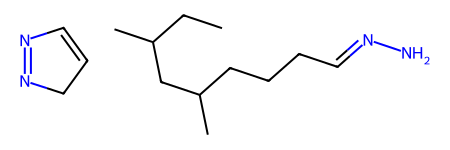

C1=CN=NC1.CCC(C)CC(C)CCCC=NN


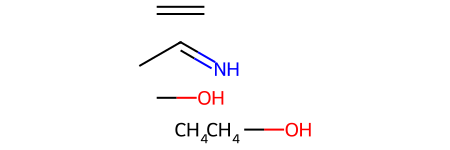

C.C.C=C.CC=N.CO.CO


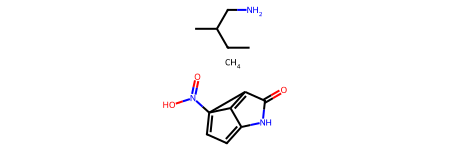

C.CCC(C)CN.O=C1NC2=CC=C3(N(=O)O)C1=C23


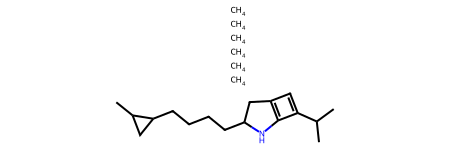

C.C.C.C.C.C.CC(C)C1=CC2=C1NC(CCCCC1CC1C)C2


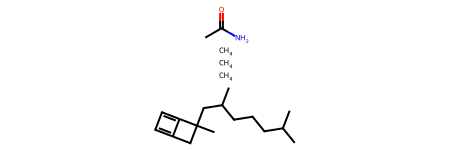

C.C.C.CC(C)CCCC(C)CC1(C)CC2=CC=C21.CC(N)=O


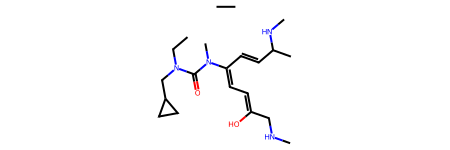

CC.CCN(CC1CC1)C(=O)N(C)C(C=CC(C)NC)=CC=C(O)CNC


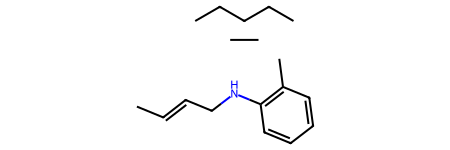

CC.CC=CCNC1=C(C)C=CC=C1.CCCCC


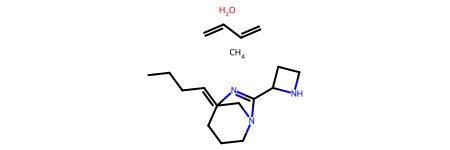

C.C=CC=C.CCCC=C12CCCN(C1)C(C1CCN1)=N2.O


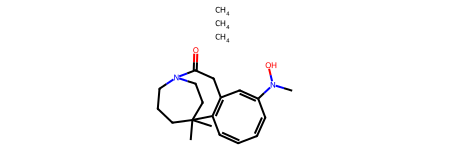

C.C.C.CN(O)C1=CC2=C(C=CC=C1)C1(C)(C)CCCN(CC1)C(=O)C2


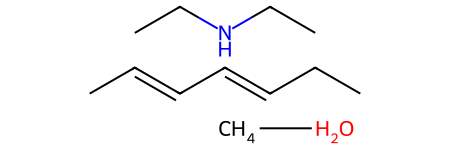

C.CC.CC=CC=CCC.CCNCC.O


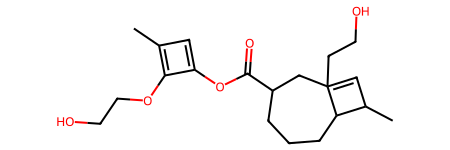

CC1=C(OCCO)C(OC(=O)C2CCCC3C(C)C=C3(CCO)C2)=C1


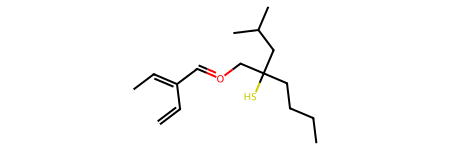

C=CC(C=OCC(S)(CCCC)CC(C)C)=CC


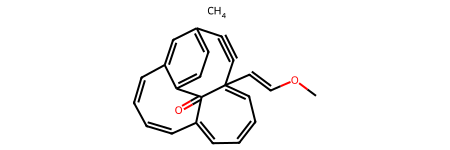

C.COC=CC12=CC=CC=C3C=CC=CC4=CC(=CC=C4C31=O)C#C2


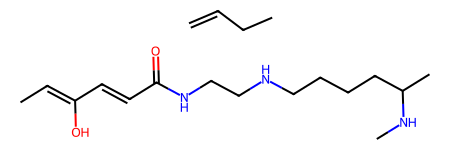

C=CCC.CC=C(O)C=CC(=O)NCCNCCCCC(C)NC


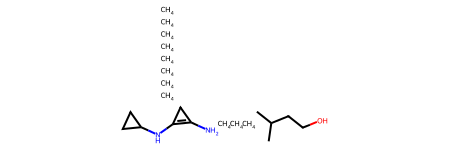

C.C.C.C.C.C.C.C.C.C.C.CC(C)CCO.NC1=C(NC2CC2)C1


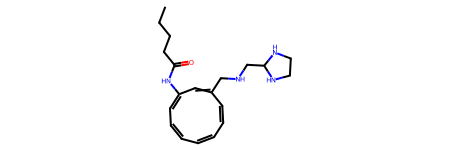

CCCCC(=O)NC1=CC=CC=CC=CC(CNCC2NCCN2)=C1


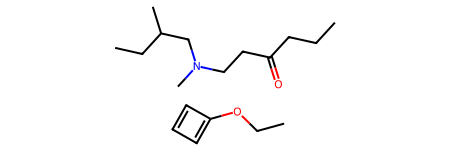

CCCC(=O)CCN(C)CC(C)CC.CCOC1=CC=C1


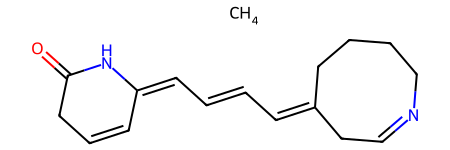

C.O=C1CC=CC(=CC=CC=C2CC=NCCCC2)N1


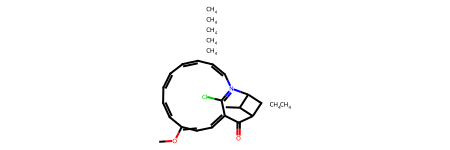

C.C.C.C.C.C.C.COC1=CC=C2C(=O)C3CC(C3C)N(=C2Cl)C=CC=CC=CC=C1


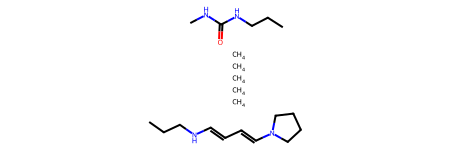

C.C.C.C.C.CCCNC(=O)NC.CCCNC=CC=CN1CCCC1


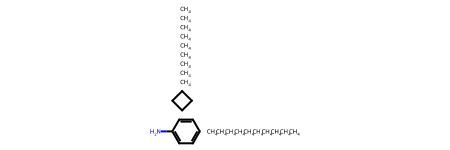

C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C1CCC1.NC1=CC=CC=C1


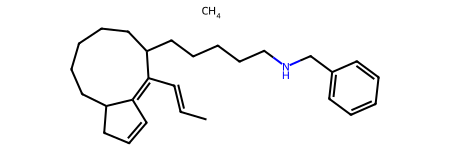

C.CC=CC1=C2C=CCC2CCCCCC1CCCCCNCC1=CC=CC=C1


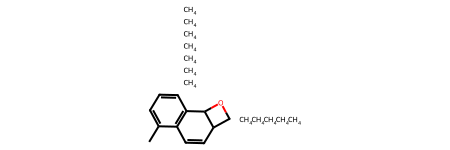

C.C.C.C.C.C.C.C.C.C.C.C.CC1=CC=CC2=C1C=CC1COC21


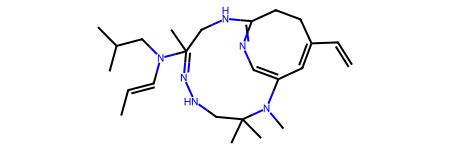

C=CC1=CC2=CN=C(CC1)NCC(C)(N(C=CC)CC(C)C)=NNCC(C)(C)N2C


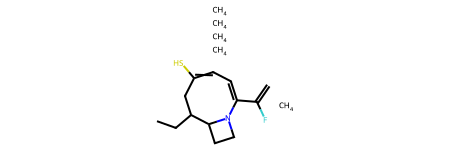

C.C.C.C.C.C=C(F)C1=CC=C(S)CC(CC)C2CCN12


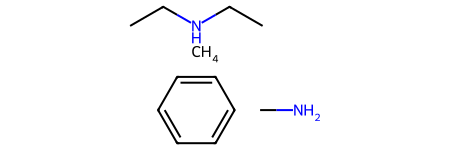

C.C1=CC=CC=C1.CCNCC.CN


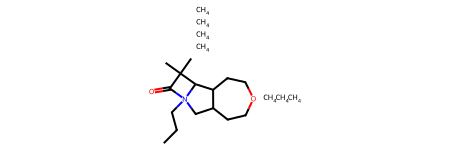

C.C.C.C.C.C.C.CCCN12CC3CCOCCC3C1C(C)(C)C2=O


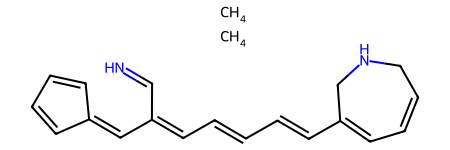

C.C.N=CC(=CC=CC=CC1=CC=CCNC1)C=C1C=CC=C1


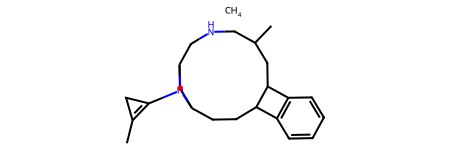

C.CC1=C(N2C3CCC4C5=C(C=CC=C5)C4CC(C)CNCC2C3)C1


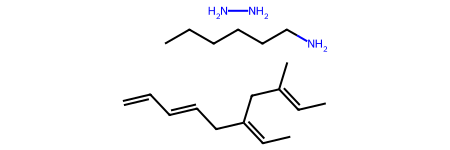

C=CC=CCC(=CC)CC(C)=CC.CCCCCCN.NN


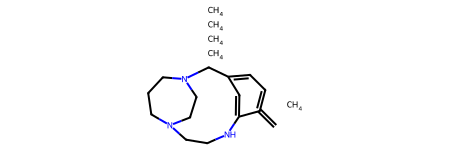

C.C.C.C.C.C=C1=CC=C2C=C1NCCN1CCCN(CC1)C2


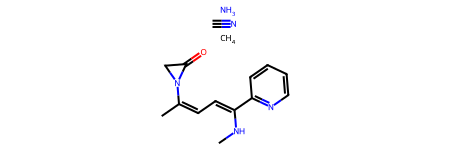

C.C#N.CNC(=CC=C(C)N1CC1=O)C1=NC=CC=C1.N
1


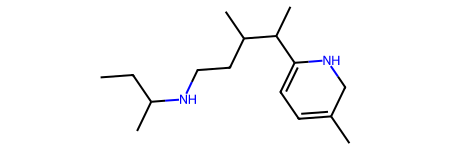

CCC(C)NCCC(C)C(C)C1=CC=C(C)CN1


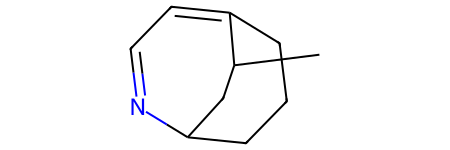

CC1CC2CCCC1=CC=N2


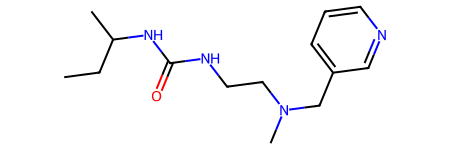

CCC(C)NC(=O)NCCN(C)CC1=CC=CN=C1


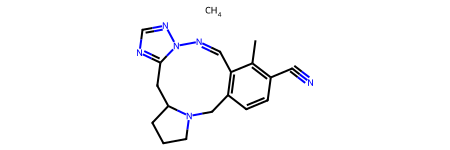

C.CC1=C(C#N)C=CC2=C1C=NN1N=CN=C1CC1CCCN1C2


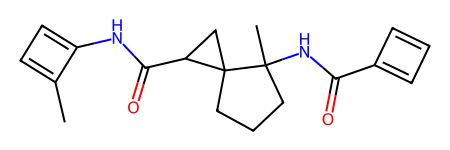

CC1=CC=C1NC(=O)C1CC12CCCC2(C)NC(=O)C1=CC=C1


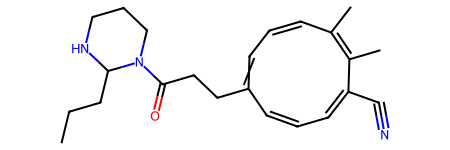

CCCC1NCCCN1C(=O)CCC1=CC=CC(C)=C(C)C(C#N)=CC=C1


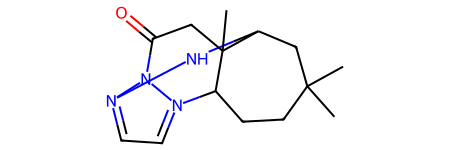

CC1(C)CCC2N3=CC=N4NC(C1)C2(C)CC(=O)N43


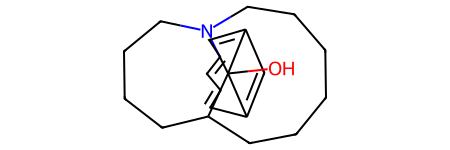

OC12(C3=CC=CC=CC1=C3)C1CCCCCCN2CCCC1


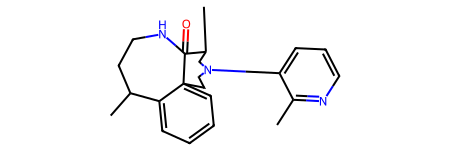

CC1=NC=CC=C1N1CCC23=CC=CC=C2C(C)CCNC3(=O)C(C)C1


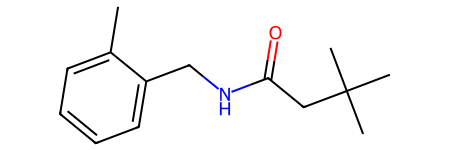

CC1=CC=CC=C1CNC(=O)CC(C)(C)C


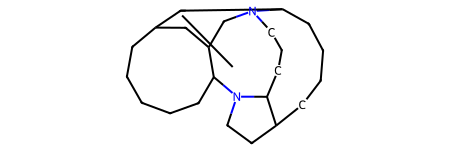

C1=C2CCCCC3CCN4C3CCCN2CC2CC1CCCCCC24


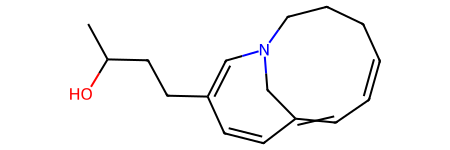

CC(O)CCC1=CN2CCCC=CC=C(C=C1)C2


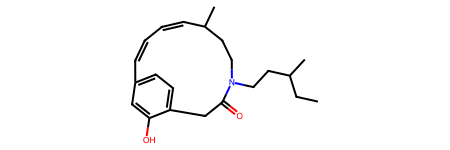

CCC(C)CCN1CCC(C)C=CC=CC2=CC=C(CC1=O)C(O)=C2


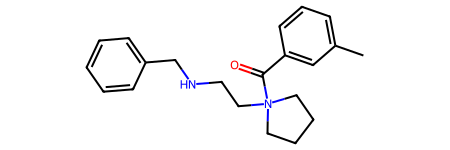

CC1=CC=CC(C(=O)N2(CCNCC3=CC=CC=C3)CCCC2)=C1


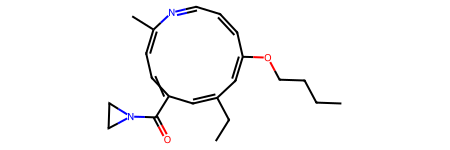

CCCCOC1=CC(CC)=CC(C(=O)N2CC2)=CC=C(C)N=CC=C1


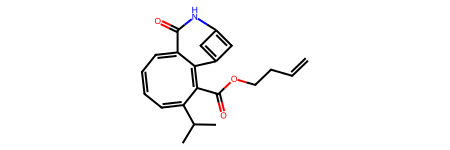

C=CCCOC(=O)C1=C2C3=CC(=C3)NC(=O)C2=CC=CC=C1C(C)C


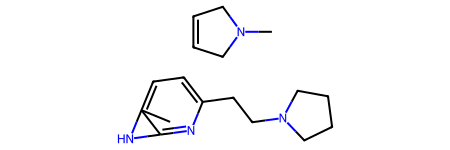

CC12=CC=C(CCN3CCCC3)N=C1N2.CN1CC=CC1


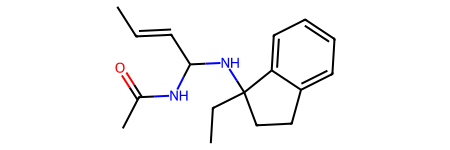

CC=CC(NC(C)=O)NC1(CC)CCC2=CC=CC=C21


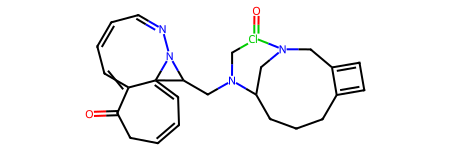

O=C1CC=CC=C23C1=CC=CC=NN2C3CN1CCl(=O)N2CC3=CC=C3CCCC1C2


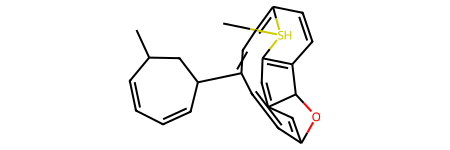

CC1C=CC=CC(C2=CC=C3C=CC4=C(C=C5C=C(C=C2)OC54)[SH]3C)C1


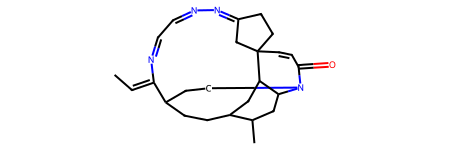

CC=C1N=CC=NN=C2CCC3(C=CC(=O)N4CCC1CCC1CC3C4CC1C)C2


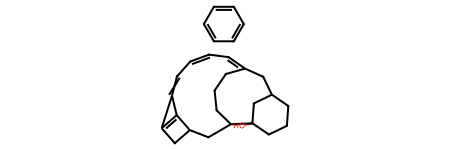

C1=CC=CC=C1.OC12CCCC(CC3=CC=CC=C4C5=C4C(C5)CC1CCC3)C2


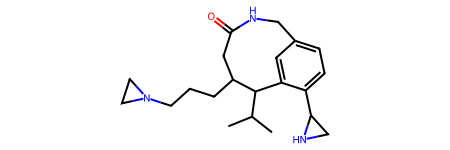

CC(C)C1C2=CC(=CC=C2C2CN2)CNC(=O)CC1CCCN1CC1


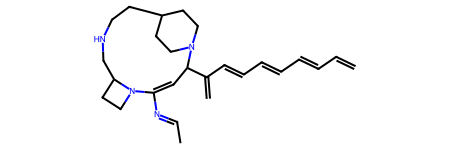

C=CC=CC=CC=CC(=C)C1C=C(N=CC)N2CCC2CNCCC2CCN1CC2


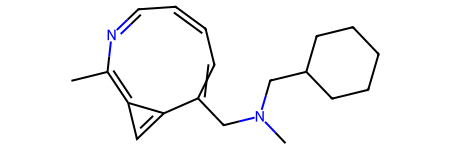

CC1=C2C=C2C(CN(C)CC2CCCCC2)=CC=CC=N1


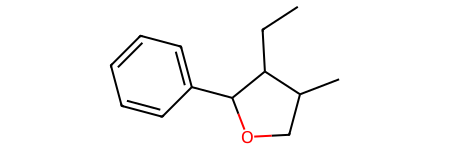

CCC1C(C)COC1C1=CC=CC=C1


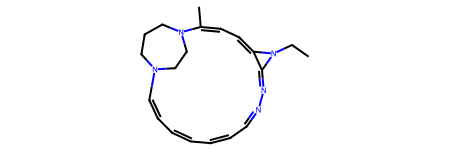

CCN1C2=CC=C(C)N3CCCN(C=CC=CC=CC=NN=C21)CC3


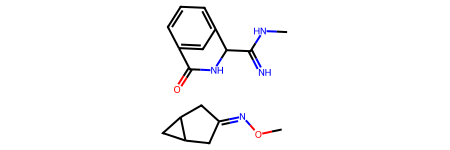

CNC(=N)C1NC(=O)C2=CC1=CC=C2.CON=C1CC2CC2C1


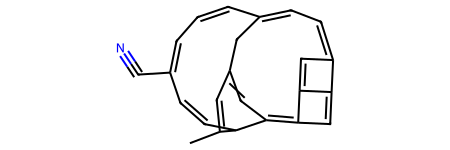

CC1=CC2=CC3=C4C=C5C(=CC=C(C=CC=C(C#N)C=CC13)C2)C=C54


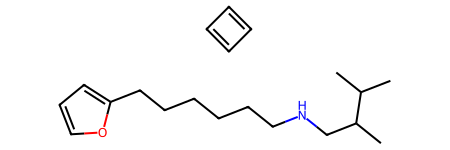

C1=CC=C1.CC(C)C(C)CNCCCCCCC1=CC=CO1


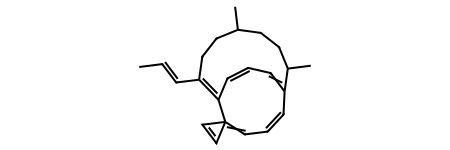

CC=CC1=C2C=CC=C(C=CC=C23C=C3)C(C)CCC(C)CC1


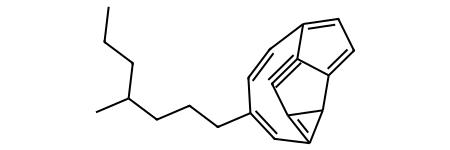

CCCC(C)CCCC1=CC2=C3C#C4C(=CC=C4C32)C=C1


In [13]:
for class_to_sample in classes:
    print(class_to_sample)
    for mol in mol_samples[class_to_sample]:
        IPython.display.display(plot_molecule(mol))
        print(rdkit.Chem.MolToSmiles(mol))

### Transmutation

In [14]:
class_1, class_2 = 0, 1
branch_time = branch_defs[min(
    range(len(branch_defs)),
    key=(lambda i: branch_defs[i][1] if (
        class_1 in branch_defs[i][0] and class_2 in branch_defs[i][0]
    ) else float("inf"))
)][1]

orig_1 = torch.stack([
    dataset[i][0].to(DEVICE) for i in 
    np.random.choice(np.where(dataset.target == class_1)[0], size=200, replace=False)
])
orig_2 = torch.stack([
    dataset[i][0].to(DEVICE) for i in 
    np.random.choice(np.where(dataset.target == class_2)[0], size=200, replace=False)
])
orig_1_adj = orig_1[:, :, :orig_1.shape[1]]
orig_1_flags = graph_net.node_flags(orig_1_adj)
orig_2_adj = orig_2[:, :, :orig_2.shape[1]]
orig_2_flags = graph_net.node_flags(orig_2_adj)

time_steps = 10
all_t = np.linspace(0, branch_time, time_steps)
forward_1_to_2 = np.empty((len(all_t),) + orig_1.shape)
backward_1_to_2 = np.empty((len(all_t) - 1,) + orig_1.shape)
forward_2_to_1 = np.empty((len(all_t),) + orig_2.shape)
backward_2_to_1 = np.empty((len(all_t) - 1,) + orig_2.shape)
for t_i, t in enumerate(all_t):
    if t_i == 0:
        forward_1_to_2[t_i], forward_2_to_1[t_i] = orig_1.cpu().numpy(), orig_2.cpu().numpy()
    else:
        forward_1_to_2[t_i] = sde.forward(
            orig_1, torch.ones(len(orig_1)).to(DEVICE) * t
        )[0].cpu().numpy()
        forward_2_to_1[t_i] = sde.forward(
            orig_2, torch.ones(len(orig_2)).to(DEVICE) * t
        )[0].cpu().numpy()

all_t_flip = np.flip(all_t)
last_1_to_2 = torch.tensor(forward_1_to_2[-1]).to(DEVICE).float()
last_2_to_1 = torch.tensor(forward_2_to_1[-1]).to(DEVICE).float()
for t_i in range(len(all_t_flip) - 1):
    last_1_to_2 = graph_adj_x_diffusion.generate_continuous_branched_samples(
        model, sde, class_2, class_time_to_branch_tensor,
        orig_1_flags, t_limit=all_t_flip[t_i], t_start=all_t_flip[t_i + 1],
        num_samples=orig_1.shape[0], initial_samples=last_1_to_2,
        num_steps=50
    )
    backward_1_to_2[t_i] = last_1_to_2.cpu().numpy()

    last_2_to_1 = graph_adj_x_diffusion.generate_continuous_branched_samples(
        model, sde, class_1, class_time_to_branch_tensor,
        orig_2_flags, t_limit=all_t_flip[t_i], t_start=all_t_flip[t_i + 1],
        num_samples=orig_2.shape[0], initial_samples=last_2_to_1,
        num_steps=50
    )
    backward_2_to_1[t_i] = last_2_to_1.cpu().numpy()

orig_1, orig_2 = orig_1.cpu().numpy(), orig_2.cpu().numpy()
before_1_to_2, after_1_to_2 = forward_1_to_2[0], backward_1_to_2[-1]
before_2_to_1, after_2_to_1 = forward_2_to_1[0], backward_2_to_1[-1]

In [15]:
# Convert to molecule objects
before_1_to_2_adj, before_1_to_2_x = samples_to_adj_x(before_1_to_2)
before_1_to_2_mols = samples_to_rdkmols(before_1_to_2_adj, before_1_to_2_x, orig_1_flags.cpu().numpy().astype(int))
after_1_to_2_adj, after_1_to_2_x = samples_to_adj_x(after_1_to_2)
after_1_to_2_mols = samples_to_rdkmols(after_1_to_2_adj, after_1_to_2_x, orig_1_flags.cpu().numpy().astype(int))
before_2_to_1_adj, before_2_to_1_x = samples_to_adj_x(before_2_to_1)
before_2_to_1_mols = samples_to_rdkmols(before_2_to_1_adj, before_2_to_1_x, orig_2_flags.cpu().numpy().astype(int))
after_2_to_1_adj, after_2_to_1_x = samples_to_adj_x(after_2_to_1)
after_2_to_1_mols = samples_to_rdkmols(after_2_to_1_adj, after_2_to_1_x, orig_2_flags.cpu().numpy().astype(int))

0 to 1
0


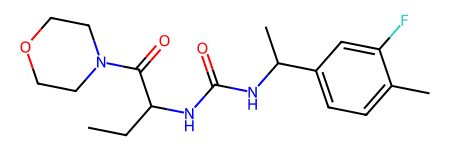

CCC(NC(=O)NC(C)C1=CC=C(C)C(F)=C1)C(=O)N1CCOCC1


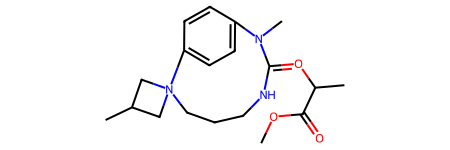

COC(=O)C(C)O=C1NCCCN2(CC(C)C2)C2=CC=C(C=C2)N1C
1


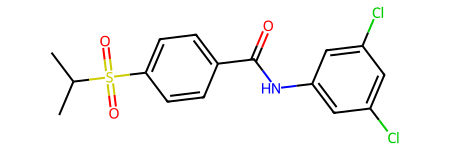

CC(C)S(=O)(=O)C1=CC=C(C(=O)NC2=CC(Cl)=CC(Cl)=C2)C=C1


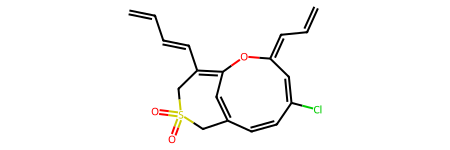

C=CC=CC1=C2C=C(C=CC(Cl)=CC(=CC=C)O2)CS(=O)(=O)C1
2


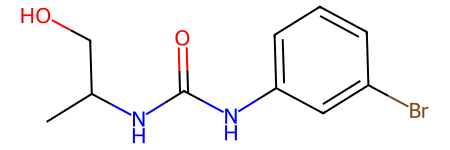

CC(CO)NC(=O)NC1=CC=CC(Br)=C1


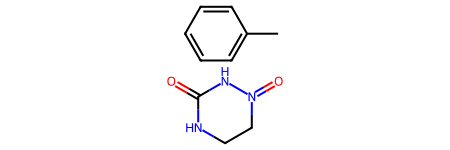

CC1=CC=CC=C1.O=C1NCCN(=O)N1
3


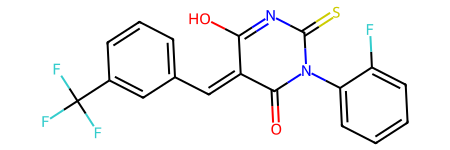

O=C1C(=CC2=CC=CC(C(F)(F)F)=C2)C(O)=NC(=S)N1C1=CC=CC=C1F


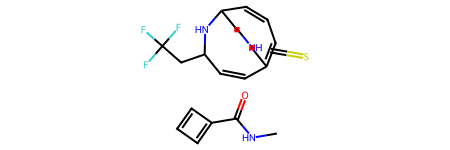

CNC(=O)C1=CC=C1.FC(F)(F)CC1C=CC2=CC=CC(CCNC2=S)N1
4


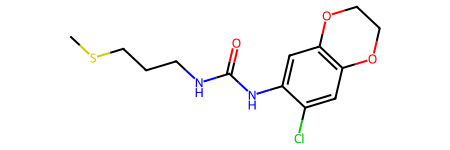

CSCCCNC(=O)NC1=CC2=C(C=C1Cl)OCCO2


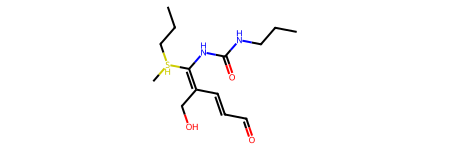

CCCNC(=O)NC(=C(C=CC=O)CO)[SH](C)CCC
5


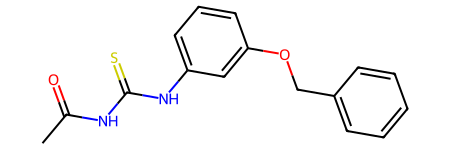

CC(=O)NC(=S)NC1=CC=CC(OCC2=CC=CC=C2)=C1


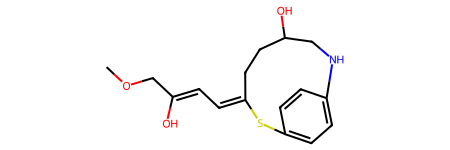

COCC(O)=CC=C1CCC(O)CNC2=CC=C(C=C2)S1
6


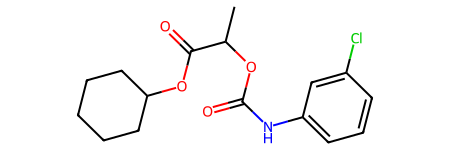

CC(OC(=O)NC1=CC=CC(Cl)=C1)C(=O)OC1CCCCC1


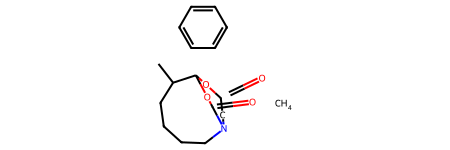

C.C1=CC=CC=C1.CC1CCCCN2CC(=O)OC1OC2=O
7


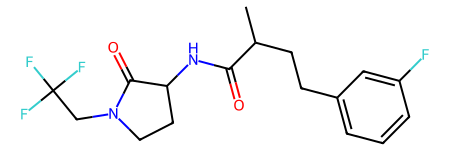

CC(CCC1=CC=CC(F)=C1)C(=O)NC1CCN(CC(F)(F)F)C1=O


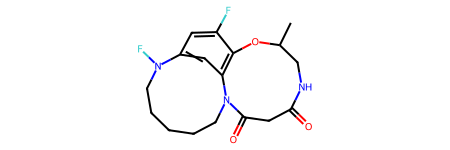

CC1CNC(=O)CC(=O)N2CCCCCN(F)C3=CC2=C(O1)C(F)=C3
8


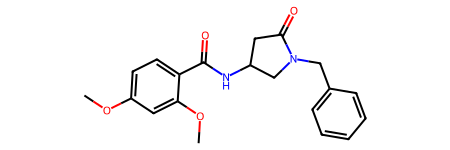

COC1=CC=C(C(=O)NC2CC(=O)N(CC3=CC=CC=C3)C2)C(OC)=C1


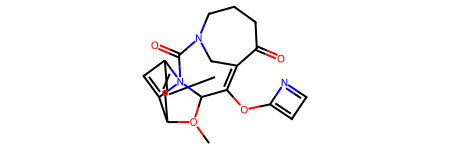

CO1C2=CC=C3C=C2N32C(=O)N3CCCC(=O)C(=C(OC4=CC=N4)C12)C3
9


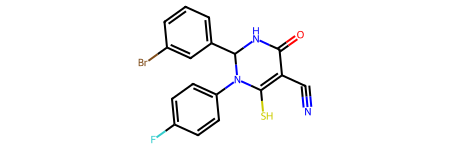

N#CC1=C(S)N(C2=CC=C(F)C=C2)C(C2=CC=CC(Br)=C2)NC1=O


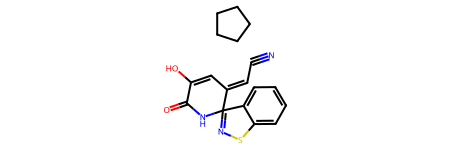

C1CCCC1.N#CC=C1C=C(O)C(=O)NC12=NSC1=CC=CC=C12
10


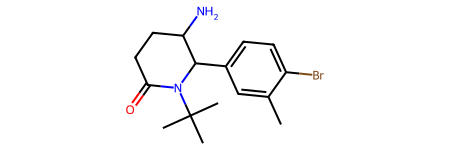

CC1=CC(C2C(N)CCC(=O)N2C(C)(C)C)=CC=C1Br


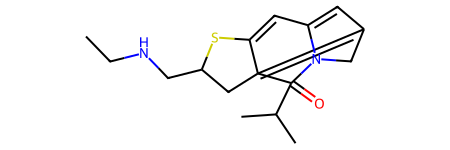

CCNCC1CC23=C4C=C(C=C2S1)N(C4)C3(=O)C(C)C
11


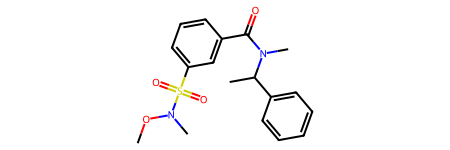

CON(C)S(=O)(=O)C1=CC=CC(C(=O)N(C)C(C)C2=CC=CC=C2)=C1


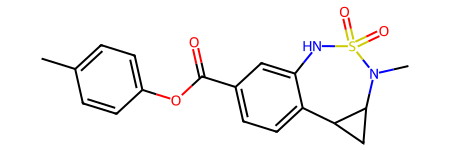

CC1=CC=C(OC(=O)C2=CC=C3C(=C2)NS(=O)(=O)N(C)C2CC32)C=C1
12


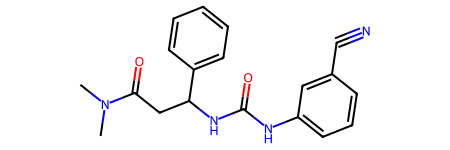

CN(C)C(=O)CC(NC(=O)NC1=CC=CC(C#N)=C1)C1=CC=CC=C1


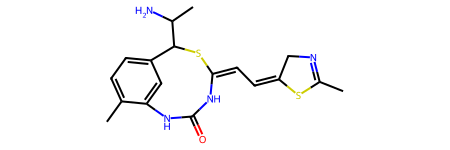

CC1=CC=C2C=C1NC(=O)NC(=CC=C1CN=C(C)S1)SC2C(C)N
13


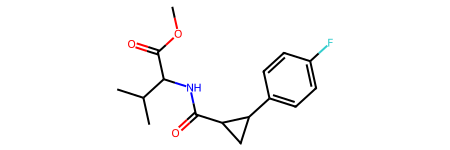

COC(=O)C(NC(=O)C1CC1C1=CC=C(F)C=C1)C(C)C


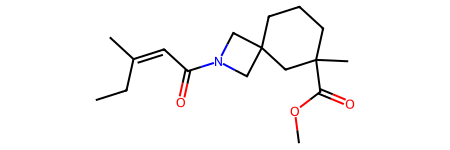

CCC(C)=CC(=O)N1CC2(CCCC(C)(C(=O)OC)C2)C1
14


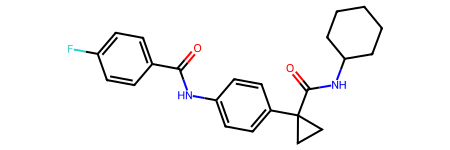

O=C(NC1=CC=C(C2(C(=O)NC3CCCCC3)CC2)C=C1)C1=CC=C(F)C=C1


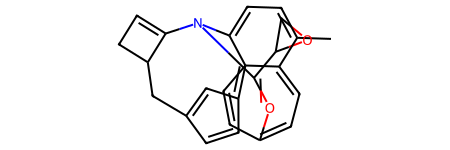

CC1=CC=C2N3C4=CCC4CC4=CC(=C25C=CC(=CC=C15)O=C3C1CO1)C=C4
15


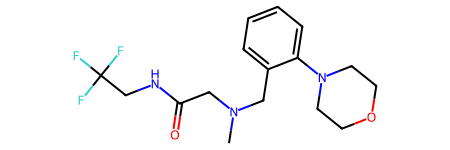

CN(CC(=O)NCC(F)(F)F)CC1=CC=CC=C1N1CCOCC1


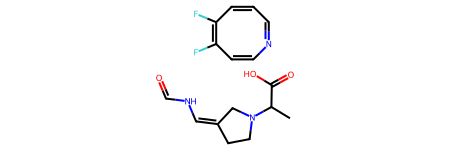

CC(C(=O)O)N1CCC(=CNC=O)C1.FC1=C(F)C=CN=CC=C1
16


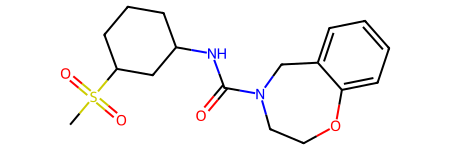

CS(=O)(=O)C1CCCC(NC(=O)N2CCOC3=CC=CC=C3C2)C1


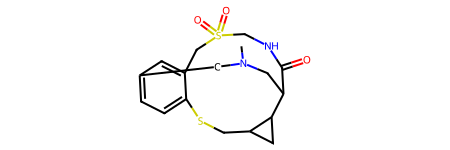

CN1CC2=CC=C3SCC4CC4C(C1)C(=O)NCS(=O)(=O)CC3=C2
17


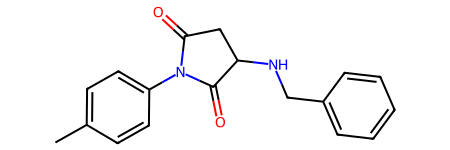

CC1=CC=C(N2C(=O)CC(NCC3=CC=CC=C3)C2=O)C=C1


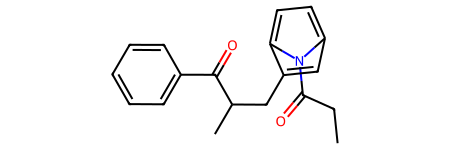

CCC(=O)N1C2=CC=C1C(CC(C)C(=O)C1=CC=CC=C1)=C2
18


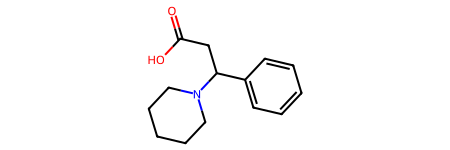

O=C(O)CC(C1=CC=CC=C1)N1CCCCC1


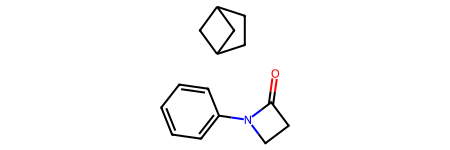

C1CC2CC1C2.O=C1CCN1C1=CC=CC=C1
19


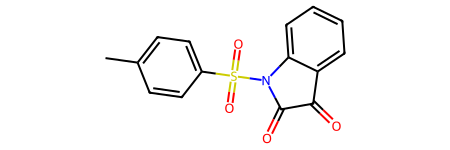

CC1=CC=C(S(=O)(=O)N2C(=O)C(=O)C3=CC=CC=C32)C=C1


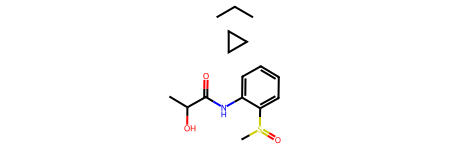

C1CC1.CC(O)C(=O)NC1=CC=CC=C1S(C)=O.CCC
20


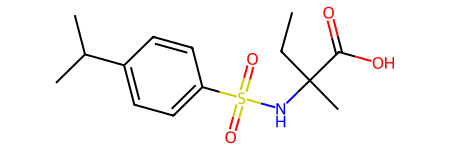

CCC(C)(NS(=O)(=O)C1=CC=C(C(C)C)C=C1)C(=O)O


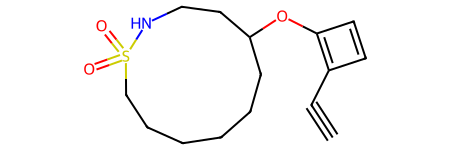

C#CC1=C(OC2CCCCCCS(=O)(=O)NCC2)C=C1
21


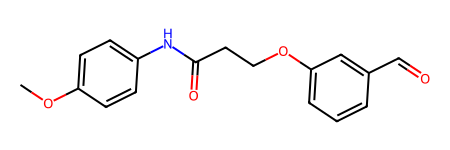

COC1=CC=C(NC(=O)CCOC2=CC=CC(C=O)=C2)C=C1


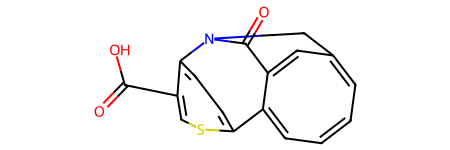

O=C(O)C1=CSC2=CC=C1N1CC3=CC=CC=C2C(=C3)C1=O
22


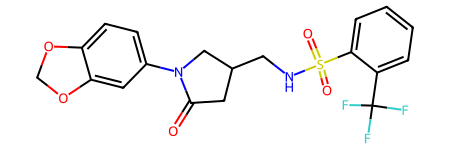

O=C1CC(CNS(=O)(=O)C2=CC=CC=C2C(F)(F)F)CN1C1=CC=C2OCOC2=C1


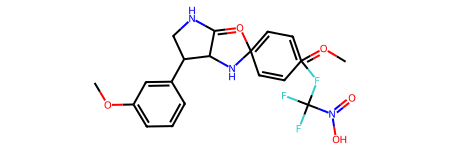

COC1=CC=CC(C2CNC3=OC4(=CC=C(=OC)(FC(F)(F)N(=O)O)C=C4)NC32)=C1
23


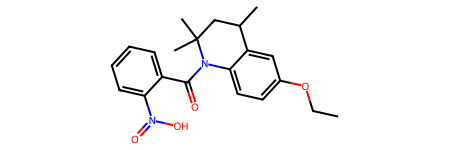

CCOC1=CC=C2C(=C1)C(C)CC(C)(C)N2C(=O)C1=CC=CC=C1N(=O)O


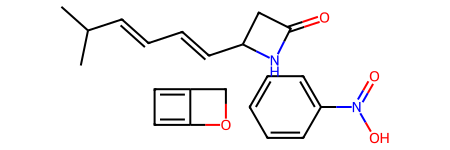

C1=C2COC2=C1.CC(C)C=CC=CC1CC(=O)N1.O=N(O)C1=CC=CC=C1
24


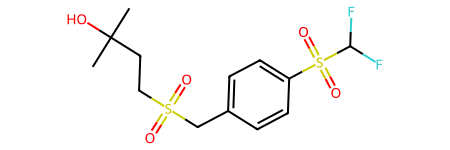

CC(C)(O)CCS(=O)(=O)CC1=CC=C(S(=O)(=O)C(F)F)C=C1


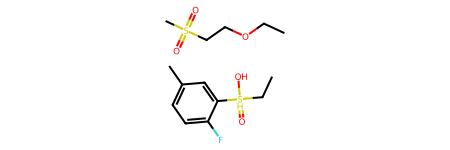

CCOCCS(C)(=O)=O.CC[SH](=O)(O)C1=CC(C)=CC=C1F
25


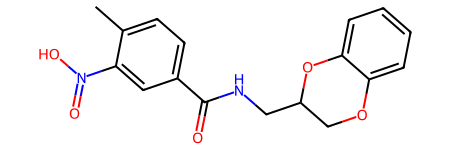

CC1=CC=C(C(=O)NCC2COC3=CC=CC=C3O2)C=C1N(=O)O


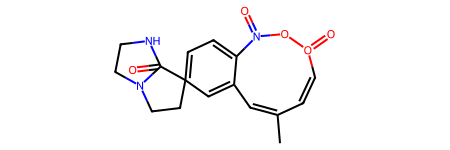

CC1=CC2=CC3(=CC=C2N(=O)OO(=O)C=C1)CCN1CCNC13=O
26


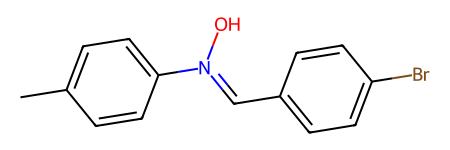

CC1=CC=C(N(O)=CC2=CC=C(Br)C=C2)C=C1


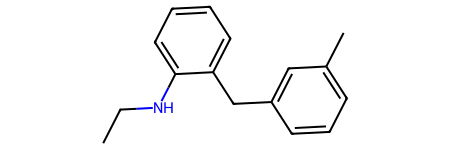

CCNC1=CC=CC=C1CC1=CC(C)=CC=C1
27


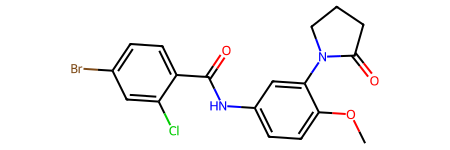

COC1=CC=C(NC(=O)C2=CC=C(Br)C=C2Cl)C=C1N1CCCC1=O


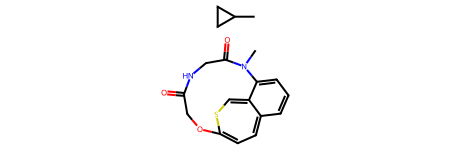

CC1CC1.CN1C(=O)CNC(=O)COC2=CC=C3C=CC=C1C3=CS2
28


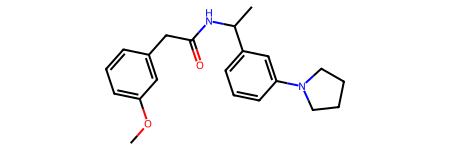

COC1=CC=CC(CC(=O)NC(C)C2=CC=CC(N3CCCC3)=C2)=C1


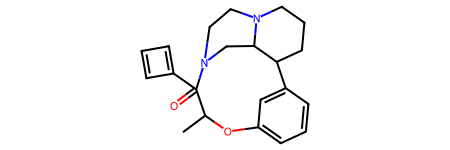

CC1OC2=CC=CC(=C2)C2CCCN3CCN(CC23)C1(=O)C1=CC=C1
29


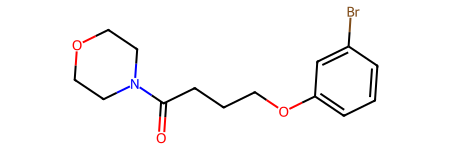

O=C(CCCOC1=CC=CC(Br)=C1)N1CCOCC1


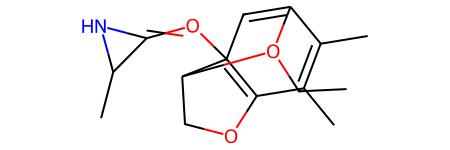

CCO1C2=CC3(O=C4NC4C)=C(OCC13)C(C)=C2C
30


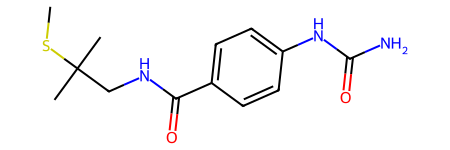

CSC(C)(C)CNC(=O)C1=CC=C(NC(N)=O)C=C1


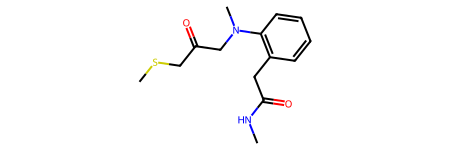

CNC(=O)CC1=C(N(C)CC(=O)CSC)C=CC=C1
31


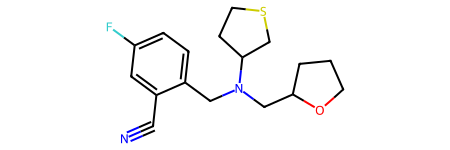

N#CC1=CC(F)=CC=C1CN(CC1CCCO1)C1CCSC1


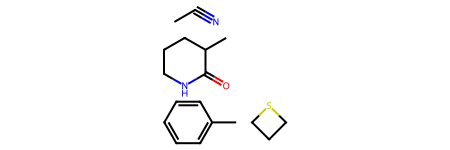

C1CSC1.CC#N.CC1=CC=CC=C1.CC1CCCNC1=O
1 to 0
0


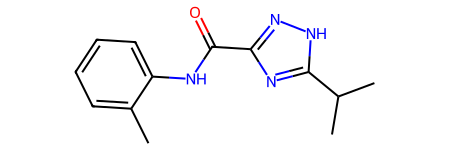

CC1=CC=CC=C1NC(=O)C1=NNC(C(C)C)=N1


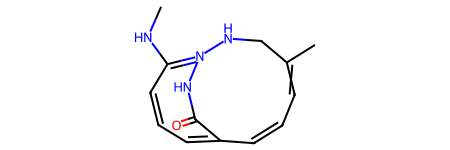

CNC1=N2NCC(C)=CC=CC(=CC=C1)C(=O)N2
1


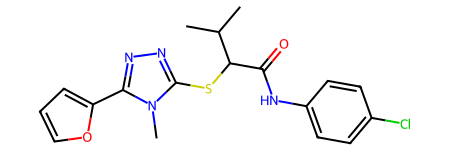

CC(C)C(SC1=NN=C(C2=CC=CO2)N1C)C(=O)NC1=CC=C(Cl)C=C1


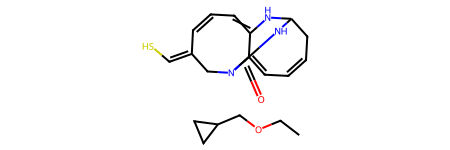

CCOCC1CC1.O=C1NC2CC=CC=C3C(=CC=CC(=CS)CN13)N2
2


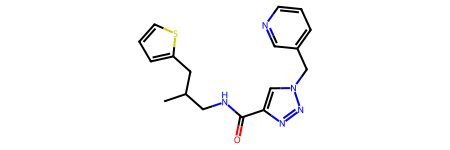

CC(CNC(=O)C1=CN(CC2=CC=CN=C2)N=N1)CC1=CC=CS1


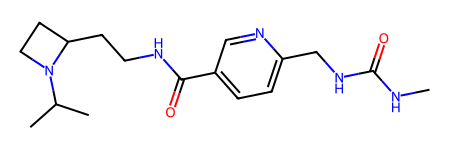

CNC(=O)NCC1=CC=C(C(=O)NCCC2CCN2C(C)C)C=N1
3


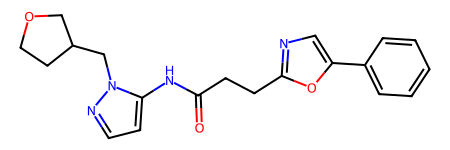

O=C(CCC1=NC=C(C2=CC=CC=C2)O1)NC1=CC=NN1CC1CCOC1


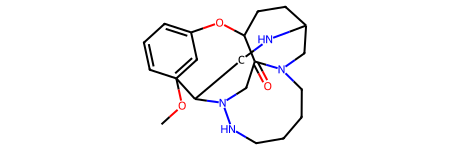

COC12=CC(=CC=C1)OC1CCC3CN4CCCCNN(CC14=O)C2CN3
4


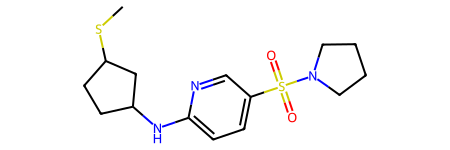

CSC1CCC(NC2=CC=C(S(=O)(=O)N3CCCC3)C=N2)C1


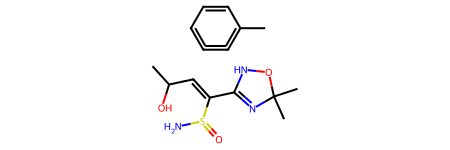

CC(O)C=C(C1=NC(C)(C)ON1)S(N)=O.CC1=C=C=CC=C1
5


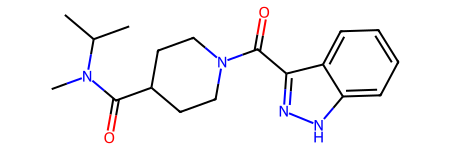

CC(C)N(C)C(=O)C1CCN(C(=O)C2=NNC3=CC=CC=C32)CC1


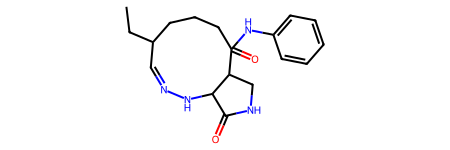

CCC1C=NNC2C(=O)NCC2C(=O)(NC2=CC=CC=C2)CCC1
6


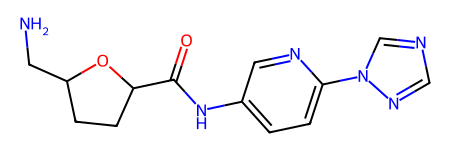

NCC1CCC(C(=O)NC2=CC=C(N3C=NC=N3)N=C2)O1


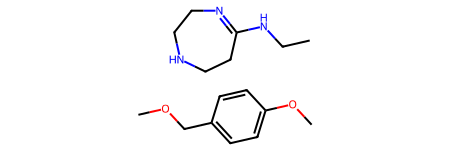

CCNC1=NCCNCC1.COCC1=CC=C(OC)C=C1
7


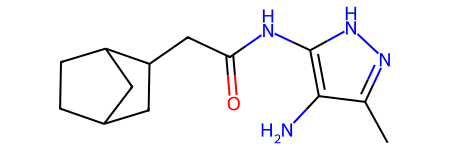

CC1=NNC(NC(=O)CC2CC3CCC2C3)=C1N


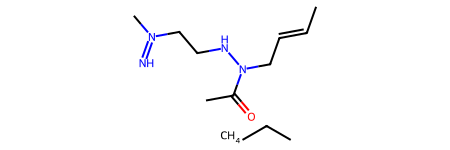

C.CC=CCN(NCCN(C)=N)C(C)=O.CCC
8


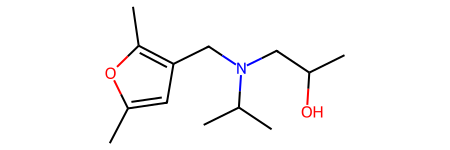

CC1=CC(CN(CC(C)O)C(C)C)=C(C)O1


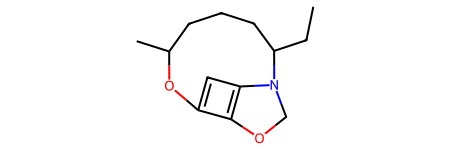

CCC1CCCC(C)OC2=CC3=C2OCN31
9


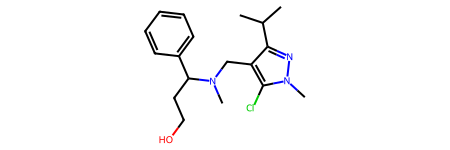

CC(C)C1=NN(C)C(Cl)=C1CN(C)C(CCO)C1=CC=CC=C1


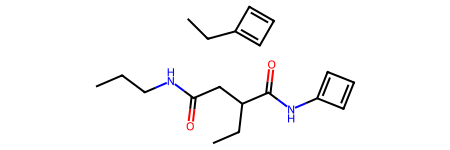

CCC1=CC=C1.CCCNC(=O)CC(CC)C(=O)NC1=CC=C1
10


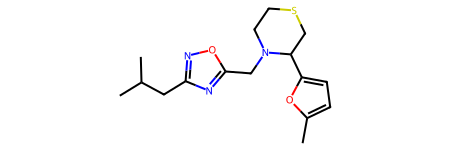

CC1=CC=C(C2CSCCN2CC2=NC(CC(C)C)=NO2)O1


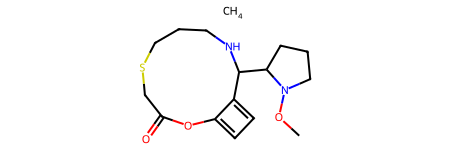

C.CON1CCCC1C1NCCCSCC(=O)OC2=CC=C21
11


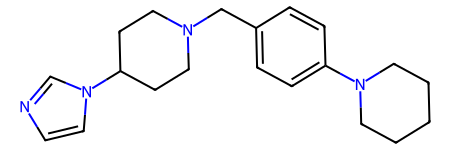

C1=CN(C2CCN(CC3=CC=C(N4CCCCC4)C=C3)CC2)C=N1


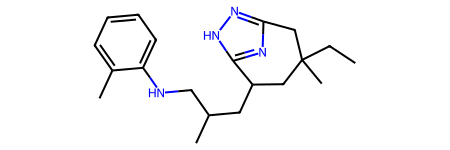

CCC1(C)CC2=NNC(=N2)C(CC(C)CNC2=CC=CC=C2C)C1
12


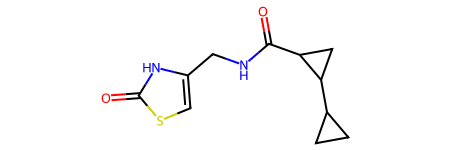

O=C1NC(CNC(=O)C2CC2C2CC2)=CS1


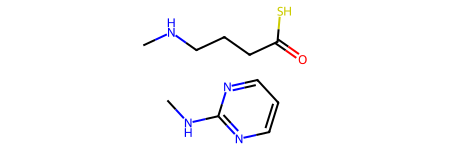

CNC1=NC=CC=N1.CNCCCC(=O)S
13


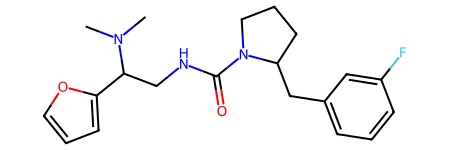

CN(C)C(CNC(=O)N1CCCC1CC1=CC=CC(F)=C1)C1=CC=CO1


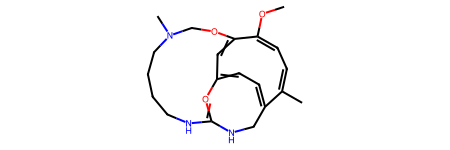

COC1=CC=C(C)C2=CC=C3C=C1OCN(C)CCCCNC(=O3)NC2
14


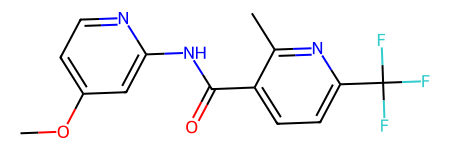

COC1=CC=NC(NC(=O)C2=CC=C(C(F)(F)F)N=C2C)=C1


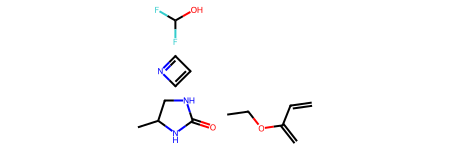

C1=CN=C1.C=CC(=C)OCC.CC1CNC(=O)N1.OC(F)F
15


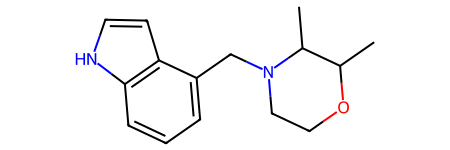

CC1OCCN(CC2=CC=CC3=C2C=CN3)C1C


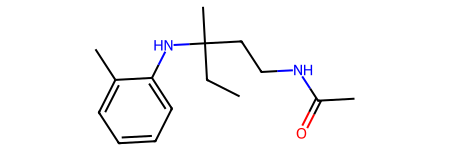

CCC(C)(CCNC(C)=O)NC1=CC=CC=C1C
16


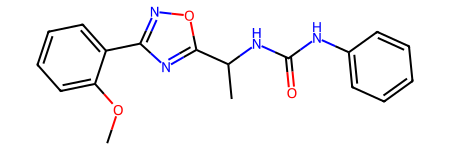

COC1=CC=CC=C1C1=NOC(C(C)NC(=O)NC2=CC=CC=C2)=N1


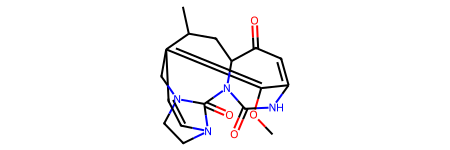

COC1=C23C=CN4CCN(C2)C4(=O)N2C(=O)NC1=CC(=O)C2CC3C
17


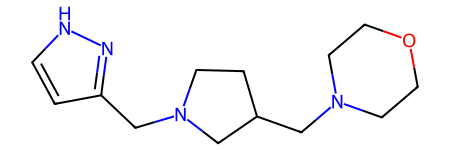

C1=CC(CN2CCC(CN3CCOCC3)C2)=NN1


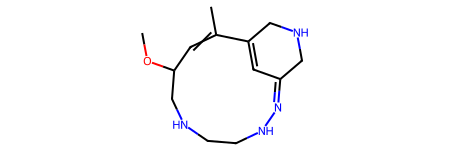

COC1C=C(C)C2=CC(=NNCCNC1)CNC2
18


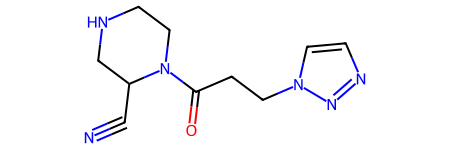

N#CC1CNCCN1C(=O)CCN1C=CN=N1


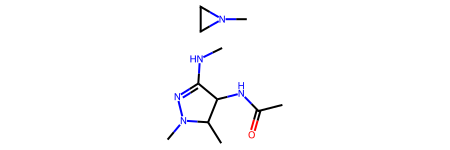

CN1CC1.CNC1=NN(C)C(C)C1NC(C)=O
19


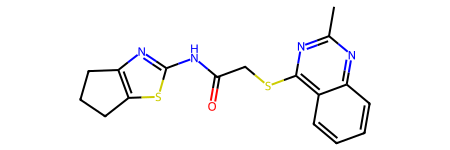

CC1=NC(SCC(=O)NC2=NC3=C(CCC3)S2)=C2C=CC=CC2=N1


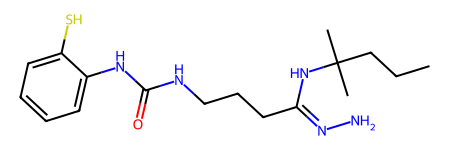

CCCC(C)(C)NC(CCCNC(=O)NC1=CC=CC=C1S)=NN
20


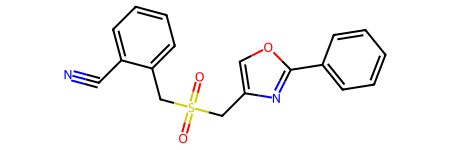

N#CC1=CC=CC=C1CS(=O)(=O)CC1=COC(C2=CC=CC=C2)=N1


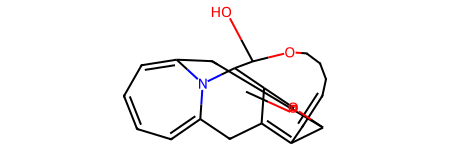

OC1OCCCC=CC2=C3CC4=CC=CC=C5CC2O=CC3C1N45
21


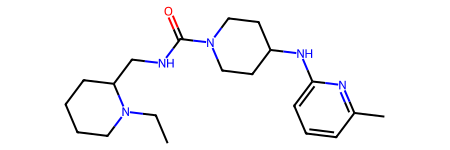

CCN1CCCCC1CNC(=O)N1CCC(NC2=CC=CC(C)=N2)CC1


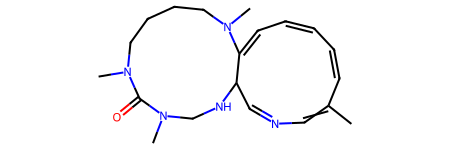

CC1=CN=CC2NCN(C)C(=O)N(C)CCCCN(C)C2=CC=CC=C1
22


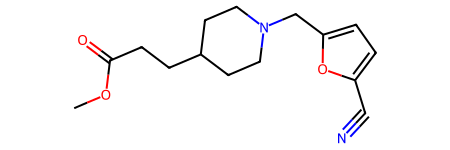

COC(=O)CCC1CCN(CC2=CC=C(C#N)O2)CC1


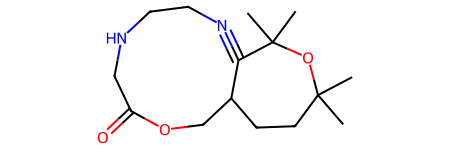

CC1(C)CCC2COC(=O)CNCCN#C2C(C)(C)O1
23


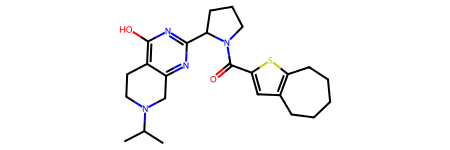

CC(C)N1CCC2=C(O)N=C(C3CCCN3C(=O)C3=CC4=C(CCCCC4)S3)N=C2C1


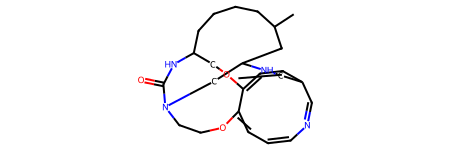

CC1CCCCC2COC3=CC=C4C=NC=CC=C3OCCN(CC(C1)NC4)C(=O)N2
24


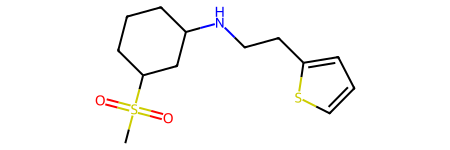

CS(=O)(=O)C1CCCC(NCCC2=CC=CS2)C1


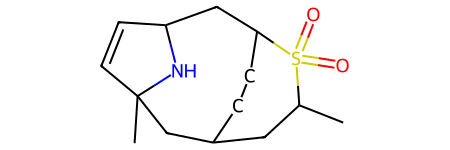

CC1CC2CCC(CC3C=CC(C)(C2)N3)S1(=O)=O
25


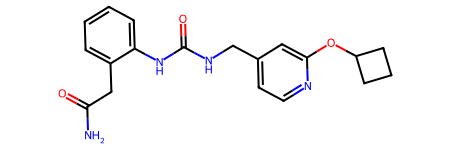

NC(=O)CC1=CC=CC=C1NC(=O)NCC1=CC=NC(OC2CCC2)=C1


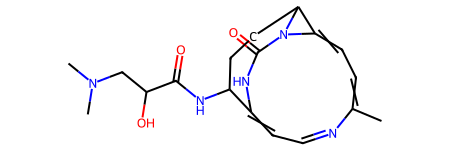

CC1=CC=C2C3CCC(NC(=O)C(O)CN(C)C)C(=CC=N1)NC(=O)N23
26


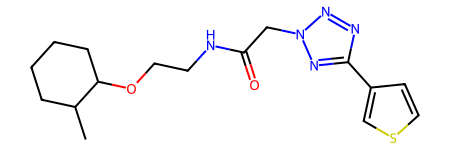

CC1CCCCC1OCCNC(=O)CN1N=NC(C2=CSC=C2)=N1


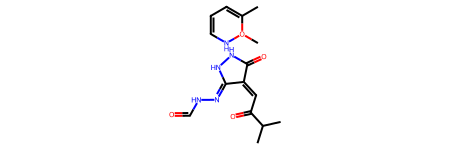

CC(C)C(=O)C=C1C(=O)NNC1=NNC=O.CC1=CC=CNO1C
27


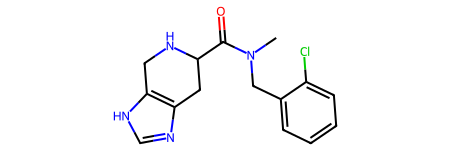

CN(CC1=CC=CC=C1Cl)C(=O)C1CC2=C(CN1)NC=N2


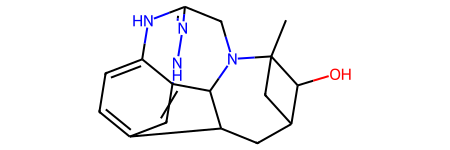

CC12CC(CC3C4=CC=C5NC6=NNC5(=C4)C3N1C6)C2O
28


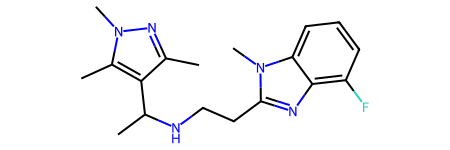

CC1=NN(C)C(C)=C1C(C)NCCC1=NC2=C(F)C=CC=C2N1C


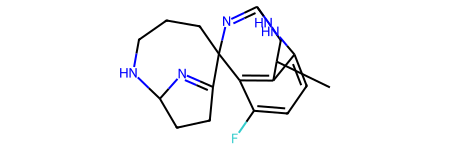

CC1CNC2=NC3(CCCNC4CCC3=N4)C3=C1C(=CC=C3F)N2
29


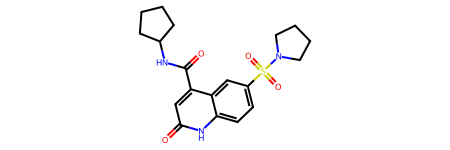

O=C1C=C(C(=O)NC2CCCC2)C2=CC(S(=O)(=O)N3CCCC3)=CC=C2N1


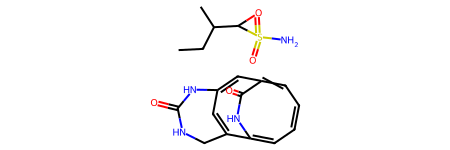

CCC(C)C1O=S1(N)=O.O=C1NCC2=CC(=CC3=CC=CC=C2NC3=O)N1
30


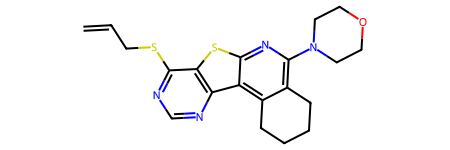

C=CCSC1=NC=NC2=C1SC1=NC(N3CCOCC3)=C3CCCCC3=C12


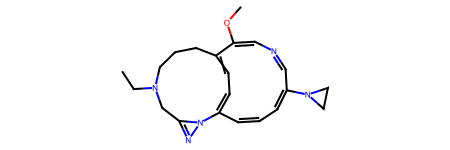

CCN1CCCC2=CC=C(C=CC=C(N3CC3)C=NC=C2OC)N2N=C2C1
31


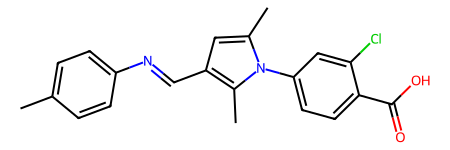

CC1=CC=C(N=CC2=C(C)N(C3=CC=C(C(=O)O)C(Cl)=C3)C(C)=C2)C=C1


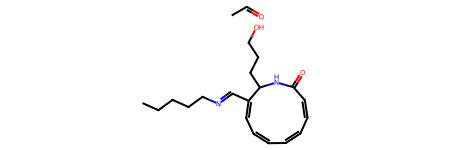

CC=O.CCCCCN=CC1=CC=CC=CC=CC(=O)NC1CCCO


In [16]:
print("%s to %s" % (class_1, class_2))
for i in range(min(32, len(before_1_to_2_mols))):
    print(i)
    IPython.display.display(plot_molecule(before_1_to_2_mols[i]))
    print(rdkit.Chem.MolToSmiles(before_1_to_2_mols[i]))
    IPython.display.display(plot_molecule(after_1_to_2_mols[i]))
    print(rdkit.Chem.MolToSmiles(after_1_to_2_mols[i]))
    
print("%s to %s" % (class_2, class_1))
for i in range(min(32, len(before_2_to_1_mols))):
    print(i)
    IPython.display.display(plot_molecule(before_2_to_1_mols[i]))
    print(rdkit.Chem.MolToSmiles(before_2_to_1_mols[i]))
    IPython.display.display(plot_molecule(after_2_to_1_mols[i]))
    print(rdkit.Chem.MolToSmiles(after_2_to_1_mols[i]))